In [8]:
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
from bindsnet.learning import PostPre
from bindsnet.analysis.plotting import (
    plot_assignments,
    plot_input,
    plot_performance,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.evaluation import all_activity, assign_labels, proportion_weighting
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_assignments, get_square_weights

import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time as t
import os
import csv
import numpy as np

import torch
from torchvision import transforms

n_workers=-1
train=True
intensity = 128
update_interval = 500
n_test = 10_000
n_train = 60_000
dt=1.0
n_epochs = 10
progress_interval = 10

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None


time = 500
network = Network()
shape = 28,28
dim = shape[0]*shape[1]
w_min = 0
w_max = 1.0

plot=False
gpu=True
seed=0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

# Determines number of workers to use
if n_workers == -1:
    n_workers = 0

n_sqrt = int(np.ceil(np.sqrt(dim)))
start_intensity = intensity

train_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

spike_record = torch.zeros((update_interval, int(time / dt), dim), device=device)


Running on Device =  cuda


In [9]:
dendrites = Input(n=dim, traces=True)
image_input = Input(n=28*28, shape=(1,28,28), traces=True)
layer = LIFNodes(n=dim, traces=True)
layer2 = LIFNodes(n=dim, traces=True)

network.add_layer(
    layer=layer, name="layer 1")
network.add_layer(
    layer=layer2, name="layer 2")
network.add_layer(
    layer=dendrites, name="dendrites")
network.add_layer(
    layer=image_input, name='simulated input')

dendrite_first_connection = Connection(
    source=dendrites, target=layer, w= 2+torch.randn(dendrites.n, layer.n) )

dropout = torch.bernoulli(0.25*torch.ones(layer.n, layer2.n))
first_second_connection = Connection(
    source=layer, target=layer2, w= dropout*(2+torch.randn(layer.n, layer2.n))/4 )

dropout = torch.bernoulli(0.25*torch.ones(layer2.n, layer.n))
recurrent_connection = Connection(
    source=layer2, target=layer, w= -dropout*(2+torch.randn(layer.n, layer2.n))/4 )

w = 0.3 * torch.rand(28*28, dim)
input_exc_conn = Connection(
                source=image_input,
                target=layer,
                w=w,
                update_rule=PostPre,
                nu=(1e-4, 1e-2),
                wmin=w_min,
                wmax=w_max,
                norm=78.4)

network.add_connection(dendrite_first_connection, 'dendrites', 'layer 1')
network.add_connection(first_second_connection, "layer 1", "layer 2")
network.add_connection(recurrent_connection, "layer 2", 'layer 1')
network.add_connection(input_exc_conn, 'simulated input', 'layer 1')

In [10]:
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(
        network.layers[layer], state_vars=["s"], time=int(time / dt), device=device
    )
    network.add_monitor(spikes[layer], name=f"{layer} spikes")

voltages = {}
for layer in set(network.layers) - {"simulated input", "dendrites"}:
    voltages[layer] = Monitor(
        network.layers[layer], state_vars=["v"], time=int(time / dt), device=device
    )
    network.add_monitor(voltages[layer], name=f"{layer} voltages")

In [11]:
redo=False
if redo:
    network.reset_state_variables()
    x = {}
    spikes_records = {}
    for layer in network.layers:
        x[layer] = []
        spikes_records[layer] = []
    for iii in tqdm(range(100)):
        input_data = torch.zeros(shape)
        input_data[4][9] = iii/100
        input_data = input_data.reshape(dim)
        input_data = input_data.expand(time, dim)
        input_data = torch.bernoulli(input_data).byte()
        inpt = {'dendrites': input_data}

        network.run(inputs=inpt, time=time)

        spikes_ = {"dendrites": network.monitors["dendrites spikes"].get("s"),
                  "layer 1": network.monitors["layer 1 spikes"].get("s"),
                  "layer 2": network.monitors["layer 2 spikes"].get("s"),
                 }
        
        for layer in set(network.layers)-{"simulated input"}:
            x[layer].append(float(input_data.sum()/500))
            spikes_records[layer].append(float(spikes_[layer].sum())/500)
        network.reset_state_variables()
        plt.ioff()
        #plot_spikes(spikes)
    redo=False
    plt.show()

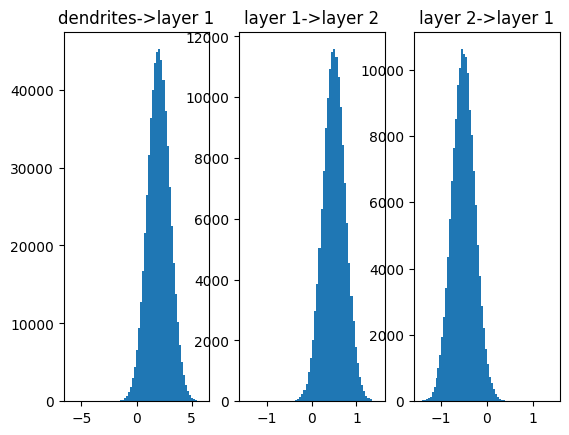

In [12]:
to_plot = set(network.connections)-{('simulated input', 'layer 1')}
_, axs = plt.subplots(1, len(to_plot))
for jjj, connection in enumerate(to_plot):
    out = [item for item in network.connections[connection].w.numpy().flatten()
          if item != 0]
    lim = max(max(out), -min(out))
    axs[jjj].hist(out, bins=50)
    axs[jjj].set_title(f"{connection[0]}->{connection[1]}")
    axs[jjj].set_xlim([-lim,lim])
plt.show()

NameError: name 'x' is not defined

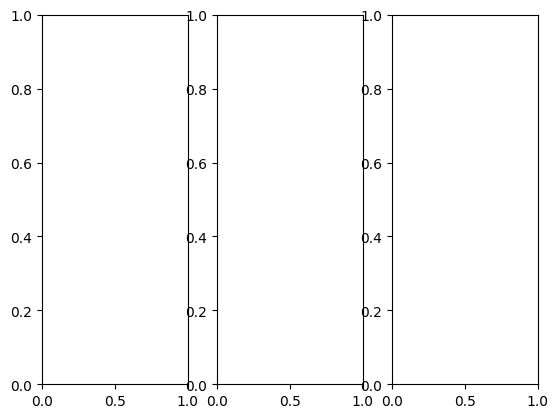

In [6]:
to_plot2 = set(network.layers)-{'simulated input'}
_, axs = plt.subplots(1, len(to_plot2))
for iii, layer in enumerate(to_plot2):
    axs[iii].scatter(x[layer][0:10], spikes_records[layer][0:10])
    axs[iii].set_title(layer)
    
print("Dendrites affer to first layer neurons")
plt.show()

## Train input layer

In [13]:

network.to(device)

n_train=1

def test():
    n_test = 1
    test_dataset = MNIST(
        PoissonEncoder(time=time, dt=dt),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
        ),
    )

    # Sequence of accuracy estimates.
    accuracy = {"all": 0, "proportion": 0}
    
    
    spike_record_t = torch.zeros((1, int(time / dt), dim), device=device)
    
    # Train the network.
    print("\nBegin testing\n")
    network.train(mode=False)
    start = t()

    pbar = tqdm(total=n_test)
    for step, batch in enumerate(test_dataset):
        if step >= n_test:
            break
        # Get next input sample.
        inputs = {"simulated input": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
        if gpu:
            inputs = {k: v.cuda() for k, v in inputs.items()}

        # Run the network on the input.
        network.run(inputs=inputs, time=time)

        # Add to spikes recording.
        spike_record_t[0] = spikes["layer 2"].get("s").squeeze()

        # Convert the array of labels into a tensor
        label_tensor = torch.tensor(batch["label"], device=device)

        # Get network predictions.
        all_activity_pred = all_activity(
            spikes=spike_record_t, assignments=assignments, n_labels=n_classes
        )
        proportion_pred = proportion_weighting(
            spikes=spike_record_t,
            assignments=assignments,
            proportions=proportions,
            n_labels=n_classes,
        )

        # Compute network accuracy according to available classification strategies.
        accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
        accuracy["proportion"] += float(
            torch.sum(label_tensor.long() == proportion_pred).item()
        )

        network.reset_state_variables()  # Reset state variables.
        pbar.set_description_str("Test progress: ")
        pbar.update()

    return "\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test), 
    "Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / n_test),
    "Progress: %d / %d (%.4f seconds)" % (epoch + 1, n_epochs, t() - start)


In [ ]:
exc_voltage_monitor = Monitor(
    network.layers["layer 1"], ["v"], time=int(time / dt), device=device
)
inh_voltage_monitor = Monitor(
    network.layers["layer 2"], ["v"], time=int(time / dt), device=device
)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")

n_classes = 10
assignments = -torch.ones(dim, device=device)
proportions = torch.zeros((dim, n_classes), device=device)
rates = torch.zeros((dim, n_classes), device=device)
accuracy = {"all": [], "proportion": []}

plot=False

print("\nBegin training.\n")
network.to(device)
start = t()
n_train=4000
network.train(mode=True)
for epoch in range(n_epochs):
    labels = []

    if epoch % progress_interval == 0:
        print("Progress: %d / %d (%.4f seconds)" % (epoch, n_epochs, t() - start))
        start = t()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
    )

    for step, batch in enumerate(tqdm(dataloader)):
        if step > n_train:
            break
        # Get next input sample.
        inputs = {"simulated input": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
        if gpu:
            inputs = {k: v.cuda() for k, v in inputs.items()}

        if step % update_interval == 0 and step > 0:
            # Convert the array of labels into a tensor
            label_tensor = torch.tensor(labels, device=device)

            # Get network predictions.
            all_activity_pred = all_activity(
                spikes=spike_record, assignments=assignments, n_labels=n_classes
            )
            proportion_pred = proportion_weighting(
                spikes=spike_record,
                assignments=assignments,
                proportions=proportions,
                n_labels=n_classes,
            )

            # Compute network accuracy according to available classification strategies.
            accuracy["all"].append(
                100
                * torch.sum(label_tensor.long() == all_activity_pred).item()
                / len(label_tensor)
            )
            accuracy["proportion"].append(
                100
                * torch.sum(label_tensor.long() == proportion_pred).item()
                / len(label_tensor)
            )

            print(
                "\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
                % (
                    accuracy["all"][-1],
                    np.mean(accuracy["all"]),
                    np.max(accuracy["all"]),
                )
            )
            print(
                "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f"
                " (best)\n"
                % (
                    accuracy["proportion"][-1],
                    np.mean(accuracy["proportion"]),
                    np.max(accuracy["proportion"]),
                )
            )

            # Assign labels to excitatory layer neurons.
            assignments, proportions, rates = assign_labels(
                spikes=spike_record,
                labels=label_tensor,
                n_labels=n_classes,
                rates=rates,
            )

            labels = []

        labels.append(batch["label"])

        # Run the network on the input.
        network.run(inputs=inputs, time=time)

        # Get voltage recording.
        exc_voltages = exc_voltage_monitor.get("v")
        inh_voltages = inh_voltage_monitor.get("v")

        # Add to spikes recording.
        spike_record[step % update_interval] = spikes["layer 1"].get("s").squeeze()
        spikes_ = {layer: spikes[layer].get("s") for layer in spikes}

        # Optionally plot various simulation information.
        if plot:
            image = batch["image"].view(28, 28)
            inpt = inputs["simulated input"].view(time, 784).sum(0).view(28, 28)
            input_exc_weights = network.connections[("simulated input", "layer 1")].w
            square_weights = get_square_weights(
                input_exc_weights.view(784, dim), n_sqrt, 28
            )
            square_assignments = get_square_assignments(assignments, n_sqrt)
            spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
            voltages = {"layer 1": exc_voltages, "layer 2": inh_voltages}
            inpt_axes, inpt_ims = plot_input(
                image, inpt, label=batch["label"], axes=inpt_axes, ims=inpt_ims
            )
            spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
            weights_im = plot_weights(square_weights, im=weights_im)
            assigns_im = plot_assignments(square_assignments, im=assigns_im)
            perf_ax = plot_performance(accuracy, x_scale=update_interval, ax=perf_ax)
            voltage_ims, voltage_axes = plot_voltages(
                voltages, ims=voltage_ims, axes=voltage_axes, plot_type="line"
            )


        if (step % 100) == 0:
            weights = network.connections['simulated input', 'layer 1'].w.cpu().numpy()
            print(f"Saved file {step}")
            np.savetxt(f"weightsStep{step}Epoch{epoch}.csv", weights, delimiter=",")
            layer1spikes = np.array(torch.tensor(spikes_['layer 1'].cpu(), dtype=int).sum(dim=0)).reshape(shape)
            np.savetxt(f"spikesStep{step}Epoch{epoch}.csv", layer1spikes, delimiter=",")

            plt.pause(1e-8)

        network.reset_state_variables()  # Reset state variables.


Begin training.

Progress: 0 / 10 (0.0037 seconds)


  0%|                                                 | 0/60000 [00:00<?, ?it/s]

Saved file 0


  0%|                                    | 100/60000 [05:54<66:23:05,  3.99s/it]

Saved file 100


  0%|                                    | 200/60000 [12:16<56:15:35,  3.39s/it]

Saved file 200


  0%|▏                                   | 300/60000 [18:33<62:36:34,  3.78s/it]

Saved file 300


  1%|▏                                   | 400/60000 [24:40<59:35:51,  3.60s/it]

Saved file 400


  1%|▎                                   | 500/60000 [30:07<50:01:02,  3.03s/it]


All activity accuracy: 9.60 (last), 9.60 (average), 9.60 (best)
Proportion weighting accuracy: 9.60 (last), 9.60 (average), 9.60 (best)

Saved file 500


  1%|▎                                   | 600/60000 [35:51<74:40:47,  4.53s/it]

Saved file 600


  1%|▍                                   | 646/60000 [38:43<65:46:10,  3.99s/it]

In [12]:
print("done")

In [15]:
redo =True
network.train(mode=False)
network.to('cpu')
if redo:
    network.reset_state_variables()
    x = {}
    spikes_records = {}
    spikes_records2 = {}
    for layer in network.layers:
        x[layer] = []
        spikes_records[layer] = []
        spikes_records2[layer] = []
        
    for iii in tqdm(range(100)):
        input_data = torch.zeros(shape)
        input_data[4][9] = iii/100
        input_data = input_data.reshape(dim)
        input_data = input_data.expand(time, dim)
        input_data = torch.bernoulli(input_data).byte()
        inpt = {'dendrites': input_data,
                "simulated input": next(iter(train_dataset))["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
        network.run(inputs=inpt, time=time)

        spikes_ = {"dendrites": network.monitors["dendrites spikes"].get("s"),
                  "layer 1": network.monitors["layer 1 spikes"].get("s"),
                  "layer 2": network.monitors["layer 2 spikes"].get("s"),
                 }
        network.reset_state_variables()
        
        inpt = {"simulated input": next(iter(train_dataset))["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
        network.run(inputs=inpt, time=time)

        spikes_2 = {"dendrites": network.monitors["dendrites spikes"].get("s"),
                  "layer 1": network.monitors["layer 1 spikes"].get("s"),
                  "layer 2": network.monitors["layer 2 spikes"].get("s"),
                 }
        
        for layer in set(network.layers)-{"simulated input"}:
            x[layer].append(float(input_data.sum()/500))
            spikes_records[layer].append(float(spikes_[layer].sum())/500)
            spikes_records2[layer].append(float(spikes_2[layer].sum())/500)
        network.reset_state_variables()
        plt.ioff()
        #plot_spikes(spikes)
    redo=False
    plt.show()

  2%|▊                                          | 2/100 [00:11<09:04,  5.56s/it]


KeyboardInterrupt: 

Dendrites affer to first layer neurons


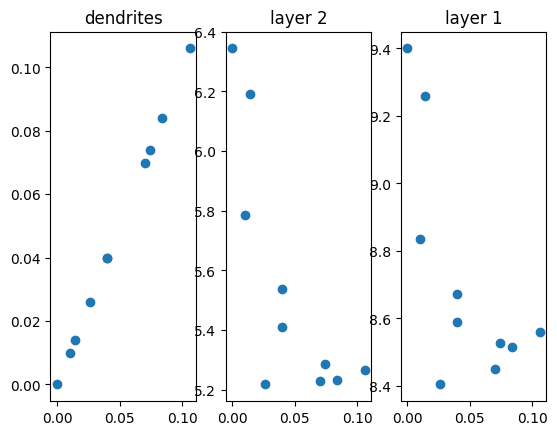

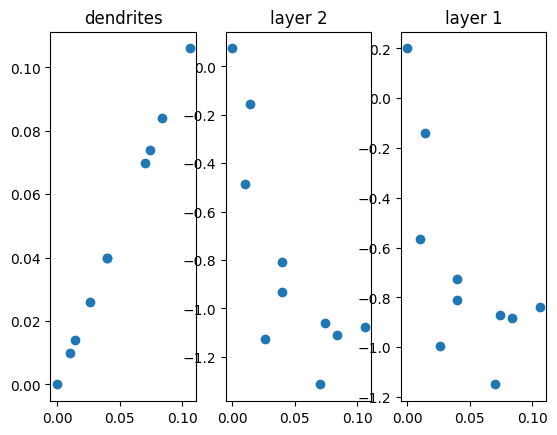

In [32]:

to_plot2 = set(network.layers)-{'simulated input'}
_, axs = plt.subplots(1, len(to_plot2))
axes_limits = []
for iii, layer in enumerate(to_plot2):
    axs[iii].scatter(x[layer][0:10], spikes_records[layer][0:10])
    axs[iii].set_title(layer)
    #axes_limits.append(axs[iii].get_ylim())
    
_, axs2 = plt.subplots(1, len(to_plot2))
for iii, layer in enumerate(to_plot2):
    axs2[iii].scatter(x[layer][0:10], np.subtract(spikes_records[layer][0:10],spikes_records2[layer][0:10]))
    axs2[iii].set_title(layer)
    #axs2[iii].set_ylim = axes_limits[iii]
    
print("Dendrites affer to first layer neurons")
plt.show()

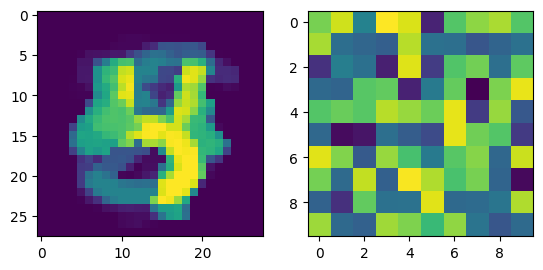

First iteration sum of STDP-adjusted connections: input->first layer and first layer->input


In [67]:
import csv
import numpy as np
weights = []
iteration_to_plot = 'weightsStep0Epoch0'
_, axs = plt.subplots(1, 2)
with open(f'{iteration_to_plot}.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    for row in plots:
        weights.append(row)

neurons = np.zeros(len(weights[0]))

for img_neuron in weights:
    for iii, connection in enumerate(img_neuron):
        neurons[iii] = neurons[iii]+float(connection)
neurons = neurons.reshape(10, 10)
axs[1].imshow(neurons)

neurons = np.zeros(len(weights))
for iii, img_neuron in enumerate(weights):
    for weight in img_neuron:
        neurons[iii] = neurons[iii]+float(weight)
neurons = neurons.reshape(28,28)
axs[0].imshow(neurons)
plt.show()
print("First iteration sum of STDP-adjusted connections: input->first layer and first layer->input")

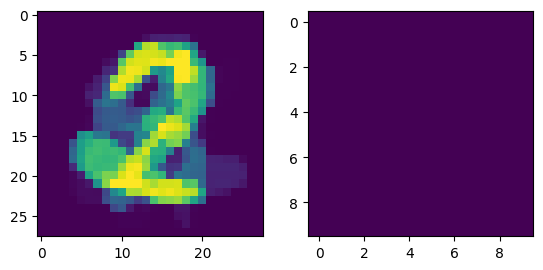

100th iteration sum of STDP-adjusted connections: input->first layer and first layer->input


In [69]:
weights = []
iteration_to_plot = 'weightsStep100Epoch0'
_, axs = plt.subplots(1, 2)
with open(f'{iteration_to_plot}.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    for row in plots:
        weights.append(row)

neurons = np.zeros(len(weights[0]))

for img_neuron in weights:
    for iii, connection in enumerate(img_neuron):
        neurons[iii] = neurons[iii]+float(connection)
neurons = neurons.reshape(10, 10)
axs[1].imshow(neurons)

neurons = np.zeros(len(weights))
for iii, img_neuron in enumerate(weights):
    for weight in img_neuron:
        neurons[iii] = neurons[iii]+float(weight)
neurons = neurons.reshape(28,28)
axs[0].imshow(neurons)
plt.show()
print("100th iteration sum of STDP-adjusted connections: input->first layer and first layer->input")